In [1]:
!date

Fri Jul  4 04:38:52 PM EDT 2025


In [2]:
pwd

'/projects/sccn/andromeda1/aglinska/BC-ABCD-denoise/Code'

### Get Files

In [3]:
import os
import numpy as np
import pandas as pd
import ants

In [4]:
import importlib

import DeepCor_utils
importlib.reload(DeepCor_utils)

import DeepCor_models
importlib.reload(DeepCor_models)

from DeepCor_utils import *
from DeepCor_models import *

numpy version: 1.20.1
sklearn version: 1.3.2
torch version: 2.4.1+cu121
AntsPy version: 0.5.4
numpy version: 1.20.1
sklearn version: 1.3.2
torch version: 2.4.1+cu121
AntsPy version: 0.5.4


In [5]:
indir = '../Data/StudyForrest/fmriprep/'
subs = [s for s in os.listdir(indir) if all((s.startswith('sub'),not s.endswith('.html')))]

subs.sort()
#print(f'{len(subs)}/{len(subs_orig)}')
print(len(subs))

14


In [6]:
# Parameters for looping. 
s = 4 # index for subject (out of 14)
r = 2 # index for run (out of 4)
analysis_name = 'test-refactor-v2' # This is be appended to the saved output files 

In [7]:
sub = subs[s]

In [8]:
epi_fn = os.path.join(indir,'{sub}/ses-localizer/func/{sub}_ses-localizer_task-objectcategories_run-{r}_bold_space-MNI152NLin2009cAsym_preproc.nii.gz')
cf_fn = os.path.join(indir,'mask_roni.nii')
gm_fn = os.path.join(indir,'mask_roi.nii')
conf_fn = os.path.join(indir,f'{sub}/ses-localizer/func/{sub}_ses-localizer_task-objectcategories_run-{r}_bold_confounds.tsv')

In [9]:
epi = ants.image_read(epi_fn.format(sub=sub,r=r))
gm = ants.image_read(gm_fn)
cf = ants.image_read(cf_fn)
df_conf = pd.read_csv(conf_fn,delimiter='\t')

In [10]:
## EPI parameters: Check that these are correct
nTR = epi.shape[-1]
t_r = round(epi.spacing[-1],2)
ndummy = 0

print(f'Number of scans: {nTR}')
print(f'Repetition Time: {t_r}')
print(f'Dummy scans to discard: {ndummy}')

Number of scans: 156
Repetition Time: 2.0
Dummy scans to discard: 0


In [11]:
# Directory where to save the outputs
ofdir_root = '../Data/StudyForrest/ensembles_last_CVAE'
ofdir = os.path.join(ofdir_root,analysis_name)
safe_mkdir(ofdir)
print(ofdir)

../Data/StudyForrest/ensembles_last_CVAE/test-refactor-v2


## Post-training analyses

In [12]:
events_fn = os.path.join(f'../Data/StudyForrest/events/{sub}_ses-localizer_task-objectcategories_run-{r}_events.tsv')
X1 = get_design_matrix(epi,events_fn)
X1

,body,face,house,object,scene,scramble,drift_1,drift_2,drift_3,constant
0.0,0.0,0.0,0.0,0.0,0.000000,0.0,-0.500000,0.165591,-0.049036,1.0
2.0,0.0,0.0,0.0,0.0,0.000000,0.0,-0.493548,0.159181,-0.045240,1.0
4.0,0.0,0.0,0.0,0.0,0.000000,0.0,-0.487097,0.152855,-0.041567,1.0
6.0,0.0,0.0,0.0,0.0,0.000000,0.0,-0.480645,0.146611,-0.038015,1.0
8.0,0.0,0.0,0.0,0.0,0.000000,0.0,-0.474194,0.140451,-0.034584,1.0
...,...,...,...,...,...,...,...,...,...,...
302.0,0.0,0.0,0.0,0.0,-0.107050,0.0,0.474194,0.140451,0.034584,1.0
304.0,0.0,0.0,0.0,0.0,-0.143768,0.0,0.480645,0.146611,0.038015,1.0
306.0,0.0,0.0,0.0,0.0,-0.127186,0.0,0.487097,0.152855,0.041567,1.0
308.0,0.0,0.0,0.0,0.0,-0.091765,0.0,0.493548,0.159181,0.045240,1.0


In [13]:
# If no post-training analyses needed, leave these empty
correlation_analyses = []
contrast_analyses = []

In [14]:
correlation_analyses.append(
    {'corr_target' : X1['face'].values,
     'filename' : os.path.join(ofdir,f'corr2face_S{s}_R{r}.nii.gz'),
     'plot' : True, 
     'ROI' : f'../Data/StudyForrest/ROIs/rFFA_final_mask_{sub}_bin.nii.gz'})

correlation_analyses.append(
    {'corr_target' : X1[['house','scene']].values.mean(axis=1),
     'filename' : os.path.join(ofdir,f'corr2place_S{s}_R{r}.nii.gz'),
     'plot' : True,
     'ROI' : f'../Data/StudyForrest/ROIs/rPPA_final_mask_{sub}_bin.nii.gz'})

contrast_analyses.append(
    {'contrast_vec' : [-1,5,-1,-1,-1,-1,0,0,0,0],
     'design_matrix' : X1,
     'filename' : os.path.join(ofdir,f'contrast_face_{s}_R{r}.nii.gz'),
     'plot' : True, 
     'ROI' : f'../Data/StudyForrest/ROIs/rFFA_final_mask_{sub}_bin.nii.gz'})

contrast_analyses.append(
    {'contrast_vec' : [-1,-1,2,-1,2,-1,0,0,0,0],
     'design_matrix' : X1,
     'filename' : os.path.join(ofdir,f'contrast_place_S{s}_R{r}.nii.gz'),
     'plot' : True,
     'ROI' : f'../Data/StudyForrest/ROIs/rPPA_final_mask_{sub}_bin.nii.gz'})

In [15]:
# Model Hyperparameters
hyperparams_cvae = {}
hyperparams_cvae['nrep'] = 20
hyperparams_cvae['epoch_num'] = 100
hyperparams_cvae['batch_size'] = 1024
hyperparams_cvae['latent_dim'] = (8,8) # Shared,Specific
hyperparams_cvae['beta'] = 0.01       
hyperparams_cvae['gamma'] = 0 # TC scaling
hyperparams_cvae['delta'] = 0 # "Denoised RONI should be zero" scaling
hyperparams_cvae['scale_MSE_GM'] = 1e3 # Scale ROI loss 
hyperparams_cvae['scale_MSE_CF'] = 1e3 # Scale RONI loss
hyperparams_cvae['scale_MSE_FG'] = 0 # "Denoised should be similar to input" scaling
# Optimizer
hyperparams_cvae['lr']=0.001
hyperparams_cvae['betas']=(0.9, 0.999)
hyperparams_cvae['eps']=1e-08

# END of user-specified parameters

In [16]:
epi,df_conf = apply_dummy(epi,df_conf,ndummy)
#gm,cf = get_roi_and_roni(anat_gm,anat_wm,anat_csf,do_plot=True) # If using individual masks

In [17]:
#use_cols = ['trans_x','trans_y','trans_z', 'rot_x','rot_y','rot_z']
use_cols = ['X','Y','Z','RotX','RotY','RotZ']
assert np.isnan(df_conf.loc[:,use_cols].values).sum()==0,'NaNs in motion'
conf = df_conf.loc[:,use_cols].values.transpose()
conf[0:3,:] = (conf[0:3,:]-conf[0:3,:].min()) / (conf[0:3,:].max()-conf[0:3,:].min())
conf[3:,:] = (conf[3:,:]-conf[3:,:].min()) / (conf[3:,:].max()-conf[3:,:].min())
print(df_conf.shape)
df_conf.head()

(156, 28)


,CSF,WhiteMatter,GlobalSignal,stdDVARS,non-stdDVARS,vx-wisestdDVARS,FramewiseDisplacement,tCompCor00,tCompCor01,tCompCor02,...,aCompCor05,Cosine00,Cosine01,Cosine02,X,Y,Z,RotX,RotY,RotZ
0,388.967740,367.716241,350.448864,NaN,NaN,NaN,NaN,-0.073152,0.073629,0.109718,...,0.063118,0.113222,0.113205,0.113176,-0.044586,-0.105250,0.079625,-0.002075,-4.058830e-04,0.000000
1,387.157902,365.300000,349.398582,1.281316,27.068560,1.087084,0.124082,0.018222,-0.116464,0.027842,...,-0.005967,0.113176,0.113021,0.112763,-0.044600,-0.149613,0.064015,-0.001304,-6.512910e-05,-0.000170
2,388.625884,364.291611,350.772925,1.309676,27.667679,1.061183,0.115360,0.083644,0.019084,-0.088604,...,-0.064924,0.113084,0.112654,0.111939,-0.071085,-0.134029,0.006567,-0.001504,-0.000000e+00,-0.000119
3,390.454818,364.711017,351.257831,1.024724,21.647905,0.916867,0.162445,0.059072,0.100485,0.001010,...,0.054493,0.112947,0.112105,0.110706,-0.068666,-0.063993,0.058091,-0.002060,1.441540e-22,-0.000332
4,393.682135,370.257798,351.219366,1.291298,27.279430,1.102332,0.026732,-0.161795,0.074058,0.027918,...,-0.050972,0.112763,0.111373,0.109069,-0.088466,-0.064023,0.058042,-0.002100,-2.662890e-22,-0.000429


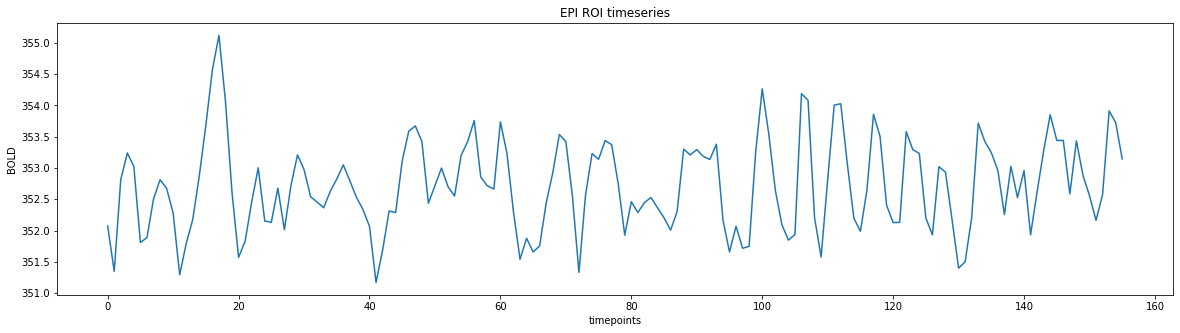

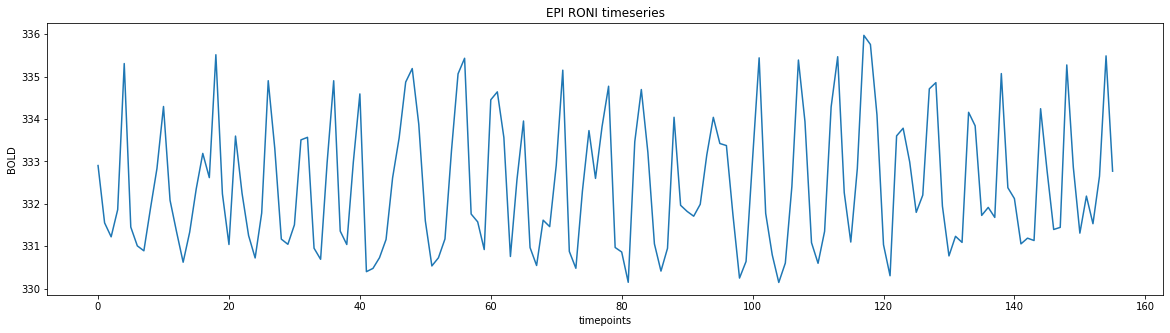

In [18]:
plot_timeseries(epi,gm,cf)

Text(0.5, 1.0, "['aCompCor01', 'aCompCor02', 'aCompCor03', 'aCompCor04', 'aCompCor05']")

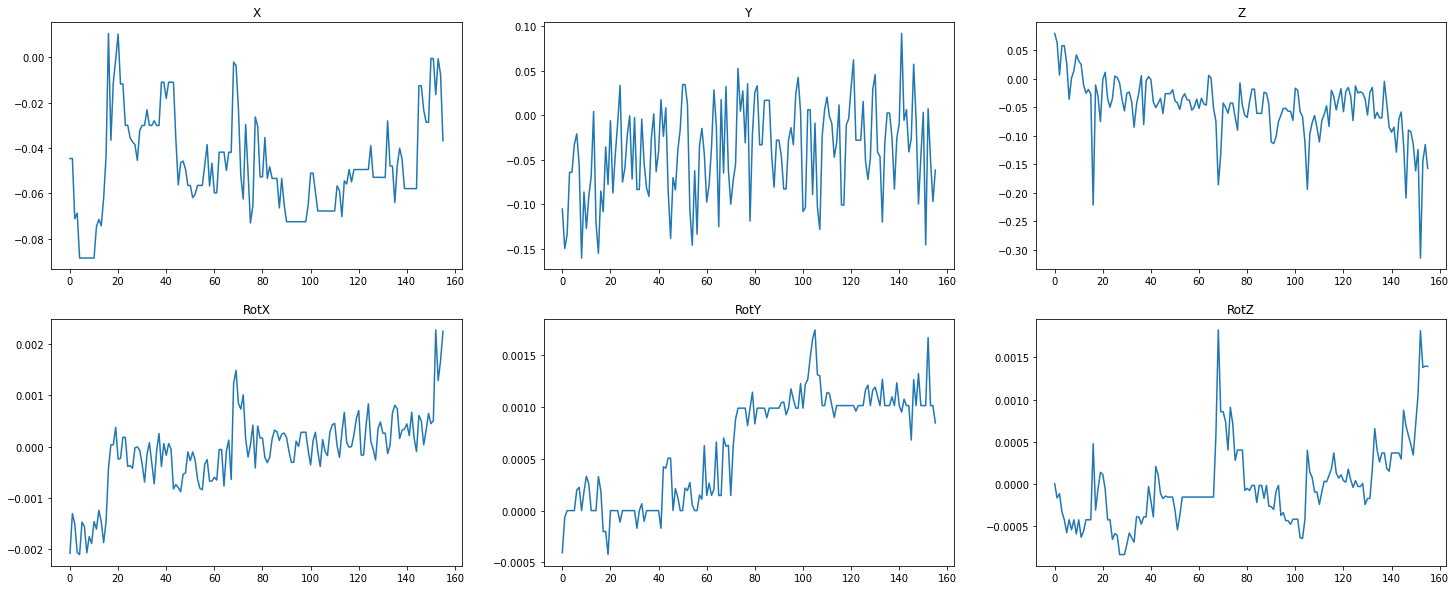

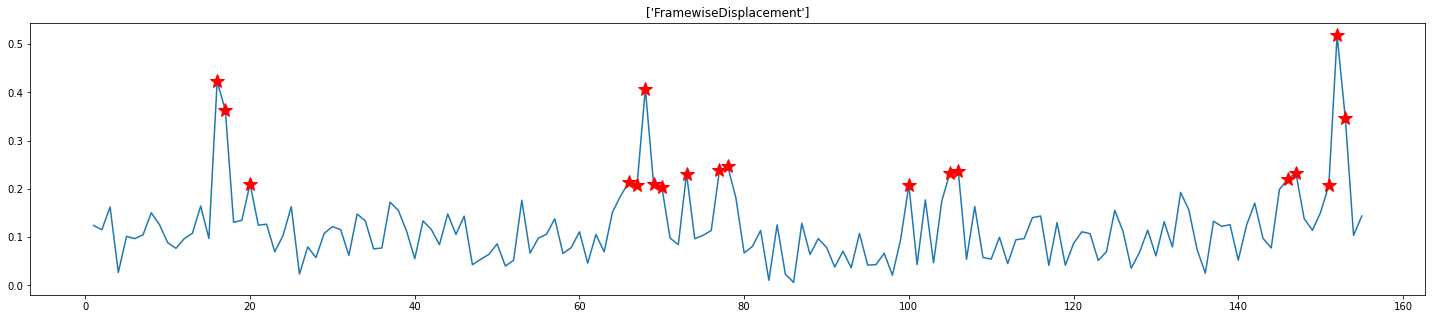

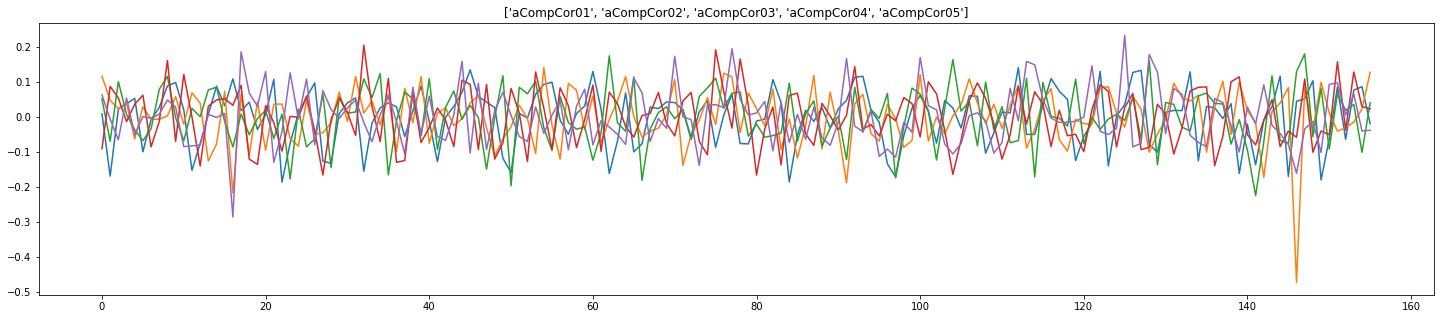

In [19]:
#conf_keys = ['trans_x','trans_y','trans_z','rot_x','rot_y','rot_z']
conf_keys = ['X','Y','Z','RotX','RotY','RotZ']
plt.figure(figsize=(25,10))
nrows = 2
ncols = 3
sp=0
for key in conf_keys:
    sp=sp+1;plt.subplot(nrows,ncols,sp)
    plt.plot(df_conf[key].values)
    plt.title(key)
    
plt.figure(figsize=(25,5))
#conf_keys = ['framewise_displacement']
conf_keys = ['FramewiseDisplacement']
plt.plot(df_conf[conf_keys].values)
thresh=.2
vec = (df_conf[conf_keys].values>thresh)*1.0*df_conf[conf_keys].values
vec[vec==0]=np.nan
plt.plot(vec,'r*',markersize=15)
plt.title(conf_keys)

plt.figure(figsize=(25,5))
#conf_keys = ['a_comp_cor_01','a_comp_cor_02',  'a_comp_cor_03',  'a_comp_cor_04','a_comp_cor_05']
conf_keys = ['aCompCor01','aCompCor02',  'aCompCor03',  'aCompCor04','aCompCor05']
plt.plot(df_conf[conf_keys].values)
plt.title(conf_keys)

In [20]:
obs_list_coords,noi_list_coords,gm,cf = get_obs_noi_list_coords(epi,gm,cf)

obs_list_coords.shape: (42574, 4, 156)
noi_list_coords.shape: (9337, 4, 156)
upsampling noi_list_coords
obs_list_coords.shape: (42574, 4, 156)
noi_list_coords.shape: (42574, 4, 156)


In [21]:
# Run some sanity check, for flat voxels (not good for training) and NaNs
assert np.isnan(obs_list_coords).sum()==0, 'NaNs in obs_list_coords'
assert np.isnan(noi_list_coords).sum()==0, 'NaNs in noi_list_coords'
assert (obs_list_coords[:,0,:].std(axis=-1)<1e-3).sum()==0,'Std0 in obs_list_coords'
assert (noi_list_coords[:,0,:].std(axis=-1)<1e-3).sum()==0,'Std0 in noi_list_coords'

In [22]:
import importlib

import DeepCor_utils
importlib.reload(DeepCor_utils)

import DeepCor_models

importlib.reload(DeepCor_models)

from DeepCor_utils import *
from DeepCor_models import *

numpy version: 1.20.1
sklearn version: 1.3.2
torch version: 2.4.1+cu121
AntsPy version: 0.5.4


In [23]:
fg_bg_corr = []

In [24]:
import traceback

nrep = hyperparams_cvae.get('nrep',20)
epoch_num = hyperparams_cvae.get('epoch_num',100)
batch_size = hyperparams_cvae.get('batch_size',512)
latent_dim = hyperparams_cvae.get('latent_dim',(8,8))
beta = hyperparams_cvae.get('beta',0.01)       
gamma = hyperparams_cvae.get('gamma',0)       
delta = hyperparams_cvae.get('delta',0)       
scale_MSE_GM = hyperparams_cvae.get('scale_MSE_GM',1e3)       
scale_MSE_CF = hyperparams_cvae.get('scale_MSE_CF',1e3)      
scale_MSE_FG = hyperparams_cvae.get('scale_MSE_FG',0) # "Denoised should be similar to input" scaling
lr = hyperparams_cvae.get('lr',0.001)

print(f'nrep: {nrep}')
print(f'epoch_num: {epoch_num}')
print(f'batch_size: {batch_size}')
print(f'latent_dim: {latent_dim}')
print(f'beta: {beta}')
print(f'gamma: {gamma}')
print(f'delta: {delta}')
print(f'scale_MSE_GM: {scale_MSE_GM}')
print(f'scale_MSE_CF: {scale_MSE_CF}')
print(f'scale_MSE_FG: {scale_MSE_FG}')
print(f'lr: {lr}')

train_inputs_coords = TrainDataset(obs_list_coords,noi_list_coords)
train_in_coords = torch.utils.data.DataLoader(train_inputs_coords, batch_size=batch_size,shuffle=True, num_workers=1,drop_last=True)

global device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f'device is {device}')
Tensor = TypeVar('torch.tensor')
conf_batch = torch.tensor(np.array([conf for _ in range(batch_size)])).to(device)

keys = ['l', 'kld_loss', 'recons_loss_roi', 'recons_loss_roni',
       'loss_recon_conf_s', 'loss_recon_conf_z', 'ncc_loss_tg',
       'ncc_loss_bg', 'ncc_loss_conf_s', 'ncc_loss_conf_z',
       'smoothness_loss', 'recons_loss_fg',  'batch_varexp',
        'tg_mu_z', 'tg_log_var_z', 'tg_mu_s', 'tg_log_var_s',
        'tg_z', 'tg_s', 'bg_log_var_z', 'bg_mu_z',
        'tg_log_var_z_mean','bg_log_var_z_mean','tg_log_var_s_mean',
        'tg_mu_z_std','bg_mu_z_std','tg_mu_s_std','batch_signal',
        'batch_noise','batch_in','batch_out','batch_varexp',
        'confounds_pred_z','confounds_pred_s',]


track = init_track(keys)
errors = []

for rep in tqdm(range(nrep)):
    try:
        track = init_track(keys)
        track['sub'] = sub
        track['s'] = s
        track['r'] = r
        track['ofdir'] = ofdir
        track['conf'] = conf
        track['rep'] = rep
        
        track_ofn = os.path.join(ofdir,f'track_S{s}_R{r}_rep_{rep}.pickle')
        model_ofn = os.path.join(ofdir,f'model_S{s}_R{r}_rep_{rep}.pickle')
        
        model = cVAE(conf_batch,4,nTR,latent_dim, beta=beta, gamma=gamma,delta=delta,scale_MSE_GM=scale_MSE_GM,scale_MSE_CF=scale_MSE_CF,scale_MSE_FG=scale_MSE_FG,freq_exp=0,freq_scale=0,do_disentangle=True)
        model.to(device)
        optimizer = optim.AdamW(model.parameters(), lr=lr, betas=(0.9, 0.999), eps=1e-08)
        
        for epoch in range(epoch_num):  # loop over the dataset multiple times    
            model.train()
            dataloader_iter_in = iter(train_in_coords)
            track['epoch'] = epoch
            for i in range(len(train_in_coords)):
                optimizer.zero_grad()
                inputs_gm,inputs_cf = next(dataloader_iter_in)

                inputs_gm = inputs_gm.float().to(device)
                inputs_cf = inputs_cf.float().to(device)

                [outputs_gm, inputs_gm, tg_mu_z, tg_log_var_z, tg_mu_s, tg_log_var_s,tg_z,tg_s] = model.forward_tg(inputs_gm)
                [outputs_cf, inputs_cf, bg_mu_z, bg_log_var_z] = model.forward_bg(inputs_cf)

                loss = model.loss_function(outputs_gm, inputs_gm, tg_mu_z, tg_log_var_z, tg_mu_s, tg_log_var_s,tg_z,tg_s, outputs_cf, inputs_cf, bg_mu_z, bg_log_var_z)

                if np.isnan(loss['loss'].detach().cpu().numpy()): raise ValueError(f'{rep}|{epoch}|{i}: loss is NaN') # If loss is NaNs, abort training and move on to the next repetition
                    
                loss['loss'].backward() # Do a backward pass
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)  # Prevent gradient explosion
                optimizer.step()
                
            track = update_track(track,model,inputs_gm,inputs_cf)
        
            show_bashboard(track,single_fig=True)
            
            outputs_gm_fg = model.forward_fg(inputs_gm)[0].detach().cpu().numpy()
            outputs_gm_bg = model.forward_bg(inputs_gm)[0].detach().cpu().numpy()
            r = correlate_columns(outputs_gm_fg[:,0,:].transpose(),outputs_gm_bg[:,0,:].transpose()).mean()
            fg_bg_corr.append(r)
            plt.plot(fg_bg_corr)
            plt.show()
            
        save_model(model_ofn,model,optimizer,epoch,loss)
        save_track(track_ofn,track)
        save_brain_signals(model,train_inputs_coords,epi,gm,ofn=os.path.join(ofdir,f'signal_S{s}_R{r}_rep_{rep}.nii.gz'),batch_size=512,kind='FG')
        #save_brain_signals(model,train_inputs_coords,epi,gm,ofn=os.path.join(ofdir,f'recon_S{s}_R{r}_rep_{rep}.nii.gz'),batch_size=512,kind='TG') # Optional to save reconstructions
        #save_brain_signals(model,train_inputs_coords,epi,gm,ofn=os.path.join(ofdir,f'noise_S{s}_R{r}_rep_{rep}.nii.gz'),batch_size=512,kind='BG') # Optional to save noise estimates       
                            
    except:
        errors.append(f'{rep}|{epoch}|{i}: loss is NaN')
        traceback.print_exc()
print('done training')
print(errors)

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

Traceback (most recent call last):
  File "<ipython-input-24-18f9c82d1d4a>", line 92, in <module>
    show_bashboard(track,single_fig=True)
  File "/projects/sccn/andromeda1/aglinska/BC-ABCD-denoise/Code/DeepCor_utils.py", line 373, in show_bashboard
    plt.show()
  File "/home/aglinska/anaconda3/lib/python3.8/site-packages/matplotlib/pyplot.py", line 353, in show
    return _backend_mod.show(*args, **kwargs)
  File "/home/aglinska/anaconda3/lib/python3.8/site-packages/ipykernel/pylab/backend_inline.py", line 41, in show
    display(
  File "/home/aglinska/anaconda3/lib/python3.8/site-packages/IPython/core/display.py", line 313, in display
    format_dict, md_dict = format(obj, include=include, exclude=exclude)
  File "/home/aglinska/anaconda3/lib/python3.8/site-packages/IPython/core/formatters.py", line 180, in format
    data = formatter(obj)
  File "/home/aglinska/anaconda3/lib/python3.8/site-packages/decorator.py", line 231, in fun
    return caller(func, *(extras + args), **kw)
 

done training
['0|32|40: loss is NaN', '1|0|40: loss is NaN', '3|73|40: loss is NaN', '4|0|0: loss is NaN', '5|0|0: loss is NaN', '6|7|27: loss is NaN', '7|0|0: loss is NaN', '8|0|0: loss is NaN', '9|0|0: loss is NaN', '10|0|0: loss is NaN', '11|0|37: loss is NaN', '12|0|0: loss is NaN', '13|0|0: loss is NaN', '14|0|40: loss is NaN', '15|0|0: loss is NaN', '16|0|0: loss is NaN', '17|8|40: loss is NaN', '18|0|0: loss is NaN', '19|0|0: loss is NaN']


In [25]:
signal_files = [os.path.join(ofdir,f) for f in os.listdir(ofdir) if all((f.startswith(f'signal_S{s}_R{r}_rep_'),f.endswith('.nii.gz')))]
track_files = [os.path.join(ofdir,f) for f in os.listdir(ofdir) if all((f.startswith(f'track_S{s}_R{r}_rep_'),f.endswith('.pickle')))] 
signal_files.sort()
track_files.sort()
print('Ensemble of {} repetitions'.format(len(signal_files)))

Ensemble of 0 repetitions


In [25]:
signals_averaged = average_signal_ensemble(signal_files,os.path.join(ofdir,f'signal_S{s}_R{r}_avg.nii.gz'))

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/aglinska/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3437, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-26-812389fda0cd>", line 1, in <module>
    signals_averaged = average_signal_ensemble(signal_files,os.path.join(ofdir,f'signal_S{s}_R{r}_avg.nii.gz'))
  File "/projects/sccn/andromeda1/aglinska/BC-ABCD-denoise/Code/DeepCor_utils.py", line 638, in average_signal_ensemble
    im = ants.image_read(signal_files[0])
IndexError: list index out of range

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/aglinska/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2061, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'IndexError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback 

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/aglinska/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3437, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-26-812389fda0cd>", line 1, in <module>
    signals_averaged = average_signal_ensemble(signal_files,os.path.join(ofdir,f'signal_S{s}_R{r}_avg.nii.gz'))
  File "/projects/sccn/andromeda1/aglinska/BC-ABCD-denoise/Code/DeepCor_utils.py", line 638, in average_signal_ensemble
    im = ants.image_read(signal_files[0])
IndexError: list index out of range

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/aglinska/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2061, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'IndexError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback 

TypeError: object of type 'NoneType' has no len()

In [ ]:
array_to_brain(obs_list_coords[:,0,:],epi,gm,os.path.join(ofdir,f'preproc_S{s}_R{r}.nii.gz'),inv_z_score=True,return_img=False)

In [ ]:
compcor = calc_and_save_compcor(epi,gm,cf,os.path.join(ofdir,f'compcor_S{s}_R{r}.nii.gz'),n_components=5,return_img=True)

In [ ]:
for analysis_spec in correlation_analyses:
    run_correlation_analysis_from_spec(analysis_spec,epi,compcor,signals_averaged,gm)

In [ ]:
for analysis_spec in contrast_analyses:
    run_contrast_analysis_from_spec(analysis_spec,epi,compcor,signals_averaged,gm)

In [ ]:
tracks = [load_pickle(track_file) for track_file in track_files]
import warnings
warnings.filterwarnings("ignore")
plt.figure(figsize=(5*9,5*5))
for track in tracks:
    try:
        show_bashboard(track,single_fig=False)
    except:
        print('bad track')